# Fit double components

In this notebook we will create a syntehtic SN3 spectrum with two Halpha components. We will then fit spectrum and plot the fit.


In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
from LUCI.LuciSim import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from  scipy import interpolate
import LUCI.LuciFit as lfit
import keras

2021-12-06 00:29:08.276337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 00:29:08.276374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Create first spectrum
lines = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
fit_function = 'sincgauss'
ampls = [10, 1, 1, 0.5, 0.45]  # Just randomly choosing these
velocity = 0  # km/s
broadening = 10  # km/s
filter_ = 'SN3'
resolution = 5000
snr = 100

spectrum_axis, spectrum = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

In [12]:
# Now create the second spectrum and add them together
lines = ['Halpha']
ampls = [6]  # Just randomly chosen
velocity = 50  # km/s

spectrum_axis2, spectrum2 = Spectrum(lines, fit_function, ampls, velocity, broadening, filter_, resolution, snr).create_spectrum()

# Add them together
spectrum += spectrum2


In [13]:
# And we can now take a look

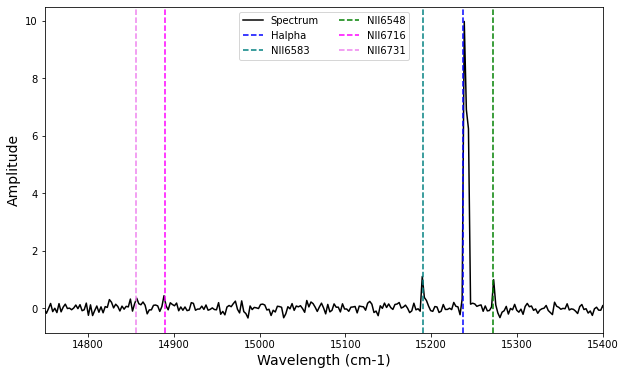

In [14]:
plt.figure(figsize=(10,6))
plt.plot(spectrum_axis, spectrum, color='black', label='Spectrum')
plt.xlim(14750, 15400)
plt.xlabel('Wavelength (cm-1)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.axvline(1e7/656.3, label='Halpha', color='blue', linestyle='--')
plt.axvline(1e7/658.3, label='NII6583', color='teal', linestyle='--')
plt.axvline(1e7/654.8, label='NII6548', color='green', linestyle='--')
plt.axvline(1e7/671.6, label='NII6716', color='magenta', linestyle='--')
plt.axvline(1e7/673.1, label='NII6731', color='violet', linestyle='--')
plt.legend(ncol=2)

plt.show()

We can clearly see that something is up with the Halpha line (because wd threw a second one there of course). Next, we can fit the components.

In [15]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('/home/carterrhea/Documents/LUCI/ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]
f = interpolate.interp1d(spectrum_axis, spectrum, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale

In [16]:
fit = lfit.Fit(spectrum, spectrum_axis, wavenumbers_syn, 'gaussian', ['Halpha', 'Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], [1,2,1,1,1,1], [1,2,1,1,1,1],
                  keras.models.load_model('/home/carterrhea/Documents/LUCI/ML/R5000-PREDICTOR-I-SN3')
                 )
fit_dict = fit.fit()

In [17]:
fit_dict['velocities']

[-99.23679351805076,
 -99.23679351805076,
 -99.23679351808384,
 -99.23679351806368,
 -99.23679351805936,
 -99.23679351808282]

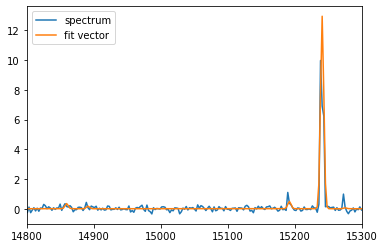

In [20]:
plt.plot(spectrum_axis, spectrum, label='spectrum')
plt.plot(spectrum_axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [21]:
fit_dict['amplitudes']

[6.477387185249369,
 6.477387185249369,
 0.4949466864195706,
 0.06152316294710018,
 0.1715652957120042,
 0.34675364428220784]